In [0]:
import os
import time

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Subset

from torchvision import datasets
from torchvision import transforms

import matplotlib.pyplot as plt
from PIL import Image

import math
import copy

from google.colab import drive
drive.mount('/content/drive')

np.random.seed(1)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
class MLP(nn.Module):
  def __init__(self, n_units, init_scale=1.0):
    super(MLP, self).__init__()

    self._n_units = copy.copy(n_units)
    self._layers = []
    for i in range(1, len(n_units)):
      layer = nn.Linear(n_units[i-1], n_units[i], bias=False)
      variance = math.sqrt(2.0 / (n_units[i-1] + n_units[i]))
      layer.weight.data.normal_(0.0, init_scale * variance)
      self._layers.append(layer)

      name = 'fc%d' % i
      if i == len(n_units) - 1:
        name = 'fc'  # the prediction layer is just called fc
      self.add_module(name, layer)


  def forward(self, x):
    x = x.view(-1, self._n_units[0])
    out = self._layers[0](x)
    for layer in self._layers[1:]:
      out = F.relu(out)
      out = layer(out)
    return out

In [0]:
cd drive/'My Drive'

/content/drive/My Drive


In [0]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Mon Apr  6 04:11:01 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
normalize = transforms.Normalize(mean=[x/255.0 for x in [125.3, 123.0, 113.9]], std=[x / 255.0 for x in [63.0, 62.1, 66.7]])

transform_train = transforms.Compose([
          transforms.ToTensor(),
          normalize])

transform_test = transforms.Compose([
        transforms.ToTensor(),
        normalize])


train_dataset = datasets.CIFAR10(root='data', 
                                train=True, 
                                transform=transform_train,
                                download=True)

test_dataset = datasets.CIFAR10(root='data', 
                                train=False, 
                                transform=transform_test,
                                download=True)




train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=128,
                          num_workers=4,
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=128,
                         num_workers=4,
                         shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


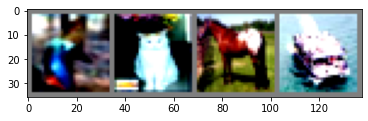

 bird   cat horse  ship


In [0]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

# functions to show an image
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images[:4]
labels = labels[:4]

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [0]:
mlp_spec = '512'
n_units = [int(x) for x in mlp_spec.split('x')] # hidden dims
n_units.append(10)  # output dim
n_units.insert(0, 32*32*3)        # input dim
model = MLP(n_units)

optimizer = torch.optim.SGD(model.parameters(), .01, momentum=0.9, weight_decay=0)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, [50, 100, 150], gamma=0.1, last_epoch=-1)

In [0]:
def compute_acc(model, data_loader):
    correct_pred, num_examples = 0, 0
    model.eval()
    for i, (features, targets) in enumerate(data_loader):
        probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        assert predicted_labels.size() == targets.size()
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100

In [0]:
criterion = nn.CrossEntropyLoss()

cost_list = []
train_acc_list = []


epoch_max = 200

for epoch in range(epoch_max):
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
    # compute output
      output = model(features)
      loss = criterion(output, targets)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      cost_list.append(loss.item())
      if not batch_idx % 150:
        print (f'Epoch: {epoch+1:03d}/{epoch_max:03d} | '
                   f'Batch {batch_idx:03d}/{len(train_loader):03d} |' 
                   f' Cost: {loss:.4f}')
    if epoch % 10 == 0:
          torch.save(model.state_dict(), 'MLP_truelabels_randomseed1')
    model.eval()
    with torch.set_grad_enabled(False): # save memory during inference
        
        train_acc = compute_acc(model, train_loader)        
        print(f'Epoch: {epoch+1:03d}/{epoch_max:03d}\n'
              f'Train ACC: {train_acc:.2f}')
        
        train_acc_list.append(train_acc)
        if np.isclose(train_acc, 0.0):
          torch.save(model.state_dict(), 'MLP_truelabels_randomseed1')
    scheduler.step()

np.save('cost_MLP_truelabels_randomseed1', cost_list)
np.save('trainacc_MLP_truelabels_randomseed1', train_acc_list)

 

Epoch: 001/200 | Batch 000/391 | Cost: 2.7925
Epoch: 001/200 | Batch 150/391 | Cost: 1.6904
Epoch: 001/200 | Batch 300/391 | Cost: 1.8806
Epoch: 001/200
Train ACC: 49.26
Epoch: 002/200 | Batch 000/391 | Cost: 1.4586
Epoch: 002/200 | Batch 150/391 | Cost: 1.3993
Epoch: 002/200 | Batch 300/391 | Cost: 1.5164
Epoch: 002/200
Train ACC: 52.88
Epoch: 003/200 | Batch 000/391 | Cost: 1.3666
Epoch: 003/200 | Batch 150/391 | Cost: 1.4365
Epoch: 003/200 | Batch 300/391 | Cost: 1.2935
Epoch: 003/200
Train ACC: 57.89
Epoch: 004/200 | Batch 000/391 | Cost: 1.1526
Epoch: 004/200 | Batch 150/391 | Cost: 1.1902
Epoch: 004/200 | Batch 300/391 | Cost: 1.0108
Epoch: 004/200
Train ACC: 58.68
Epoch: 005/200 | Batch 000/391 | Cost: 1.1011
Epoch: 005/200 | Batch 150/391 | Cost: 1.4622
Epoch: 005/200 | Batch 300/391 | Cost: 1.1940
Epoch: 005/200
Train ACC: 61.17
Epoch: 006/200 | Batch 000/391 | Cost: 1.0180
Epoch: 006/200 | Batch 150/391 | Cost: 1.0549
Epoch: 006/200 | Batch 300/391 | Cost: 1.1941
Epoch: 006/2

KeyboardInterrupt: ignored

In [0]:
model.load_state_dict(torch.load('MLP_truelabels_randomseed1'))

<All keys matched successfully>

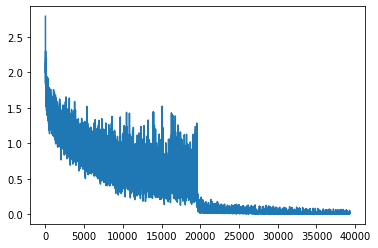

In [0]:
plt.plot(cost_list)

In [0]:
 with torch.set_grad_enabled(False): # save memory during inference
        
        train_acc = compute_acc(model, train_loader)        
        print(f'train ACC: {train_acc:.2f}')

train ACC: 99.97


In [0]:
 with torch.set_grad_enabled(False): # save memory during inference
        
        test_acc = compute_acc(model, test_loader)        
        print(f'Test ACC: {test_acc:.2f}')

Test ACC: 53.36


In [0]:
model

MLP(
  (fc1): Linear(in_features=3072, out_features=512, bias=False)
  (fc): Linear(in_features=512, out_features=10, bias=False)
)

In [0]:
!pip install weightwatcher

  Created wheel for powerlaw: filename=powerlaw-1.4.6-cp36-none-any.whl size=24787 sha256=559a0a36774f8be6416a9a63476edebb46c635af3f11820cb88d46ce9632b3d5
  Stored in directory: /root/.cache/pip/wheels/e0/27/02/08d0e2865072bfd8d7c655e290521e3feca3fc22f1ac460601
Successfully built powerlaw


Using TensorFlow backend.
2020-04-06 04:50:42,920 INFO 

python      version 3.6.9 (default, Nov  7 2019, 10:44:02) 
[GCC 8.3.0]
numpy       version 1.18.2
tensforflow version 2.2.0-rc2
keras       version 2.2.5
2020-04-06 04:50:42,921 INFO Analyzing model
/usr/local/lib/python3.6/dist-packages/powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/usr/local/lib/python3.6/dist-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/usr/local/lib/python3.6/dist-packages/powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/usr/local/lib/python3.6/dist-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


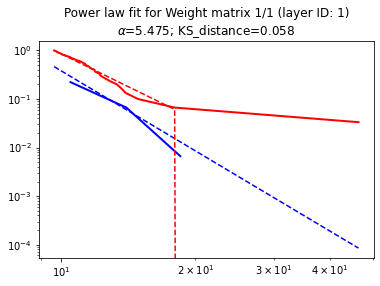

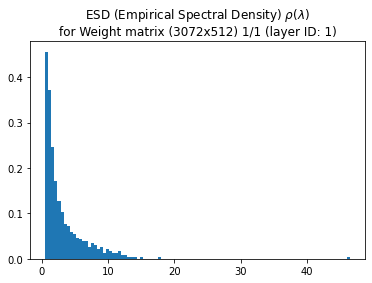

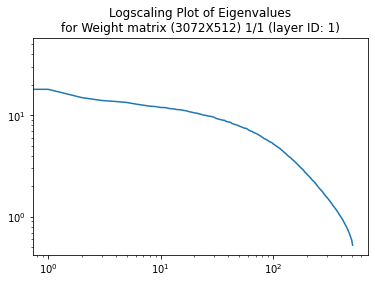

/usr/local/lib/python3.6/dist-packages/weightwatcher/RMT_Util.py:48: RuntimeWarning: divide by zero encountered in true_divide
  return x, (1/(2*np.pi*sigma*sigma*x*y))*np.sqrt((b-x)*(x-a))
/usr/local/lib/python3.6/dist-packages/weightwatcher/RMT_Util.py:48: RuntimeWarning: invalid value encountered in sqrt
  return x, (1/(2*np.pi*sigma*sigma*x*y))*np.sqrt((b-x)*(x-a))


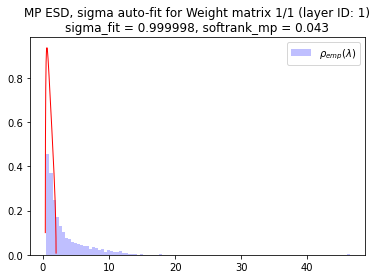

2020-04-06 04:50:47,433 INFO ### Printing results ###
2020-04-06 04:50:47,551 INFO Check: min: 0.0460611117166826, max: 0.16683232731496833, avg: 0.10644671951582546
2020-04-06 04:50:47,551 INFO Check compound: min: 0.0460611117166826, max: 0.16683232731496833, avg: 0.10644671951582546
2020-04-06 04:50:47,555 INFO CheckTF: min: False, max: False, avg: 0.0
2020-04-06 04:50:47,556 INFO CheckTF compound: min: 0.0, max: 0.0, avg: 0.0
2020-04-06 04:50:47,557 INFO Norm: min: 40.84745407104492, max: 40.84745407104492, avg: 40.84745407104492
2020-04-06 04:50:47,559 INFO Norm compound: min: 40.84745407104492, max: 40.84745407104492, avg: 40.84745407104492
2020-04-06 04:50:47,561 INFO LogNorm: min: 1.6111650466918945, max: 1.6111650466918945, avg: 1.6111650466918945
2020-04-06 04:50:47,563 INFO LogNorm compound: min: 1.6111650466918945, max: 1.6111650466918945, avg: 1.6111650466918945
2020-04-06 04:50:47,564 INFO Norm X: min: 109.00572204589844, max: 109.00572204589844, avg: 109.00572204589844
2

{'alpha': 5.474798970154679,
 'alpha_compound': 5.474798970154679,
 'alpha_weighted': 9.125477930740832,
 'alpha_weighted_compound': 9.125477930740832,
 'check': 0.10644671951582546,
 'checkTF': 0.0,
 'checkTF_compound': 0.0,
 'check_compound': 0.10644671951582546,
 'lognorm': 1.611165,
 'lognormX': 2.0374494,
 'lognormX_compound': 2.0374494,
 'lognorm_compound': 1.611165,
 'logpnorm': 9.135960640640926,
 'logpnorm_compound': 9.135960640640926,
 'logspectralnorm': 1.4081163,
 'logspectralnorm_compound': 1.4081163,
 'norm': 40.847454,
 'normX': 109.00572,
 'normX_compound': 109.00572,
 'norm_compound': 40.847454,
 'numofSpikes': 251.0,
 'numofSpikes_compound': 251.0,
 'ratio_numofSpikes': 0.4911937377690802,
 'ratio_numofSpikes_compound': 0.4911937377690802,
 'sigma_mp': 0.9999975585937502,
 'sigma_mp_compound': 0.9999975585937502,
 'softrank_mp': 0.04271113750893778,
 'softrank_mp_compound': 0.04271113750893778,
 'spectralnorm': 30.269117,
 'spectralnorm_compound': 30.269117}

In [0]:
import weightwatcher as ww
watcher = ww.WeightWatcher(model=model)
results = watcher.analyze(plot=True, alphas=True, mp_fit=True, spectralnorms=True)

watcher.get_summary()